<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Comparing--Deep-Learning-APIs-for-Image-Multi-Label-Classification" data-toc-modified-id="Comparing--Deep-Learning-APIs-for-Image-Multi-Label-Classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Comparing  Deep Learning APIs for Image Multi-Label Classification</a></span><ul class="toc-item"><li><span><a href="#Inception-V3" data-toc-modified-id="Inception-V3-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Inception V3</a></span></li><li><span><a href="#OpenAI-Clip" data-toc-modified-id="OpenAI-Clip-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>OpenAI Clip</a></span></li></ul></li><li><span><a href="#Labeling-the-data" data-toc-modified-id="Labeling-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Labeling the data</a></span></li></ul></div>

# Computer Vision

In [1]:
# Models
from models.inception_v3 import Inception_V3
from models.openai_clip import OpenAI_clip

# Libraries
import numpy as np
import os
from IPython.display import Image as Image_display
from IPython.display import display

##  Comparing  Deep Learning APIs for Image Multi-Label Classification

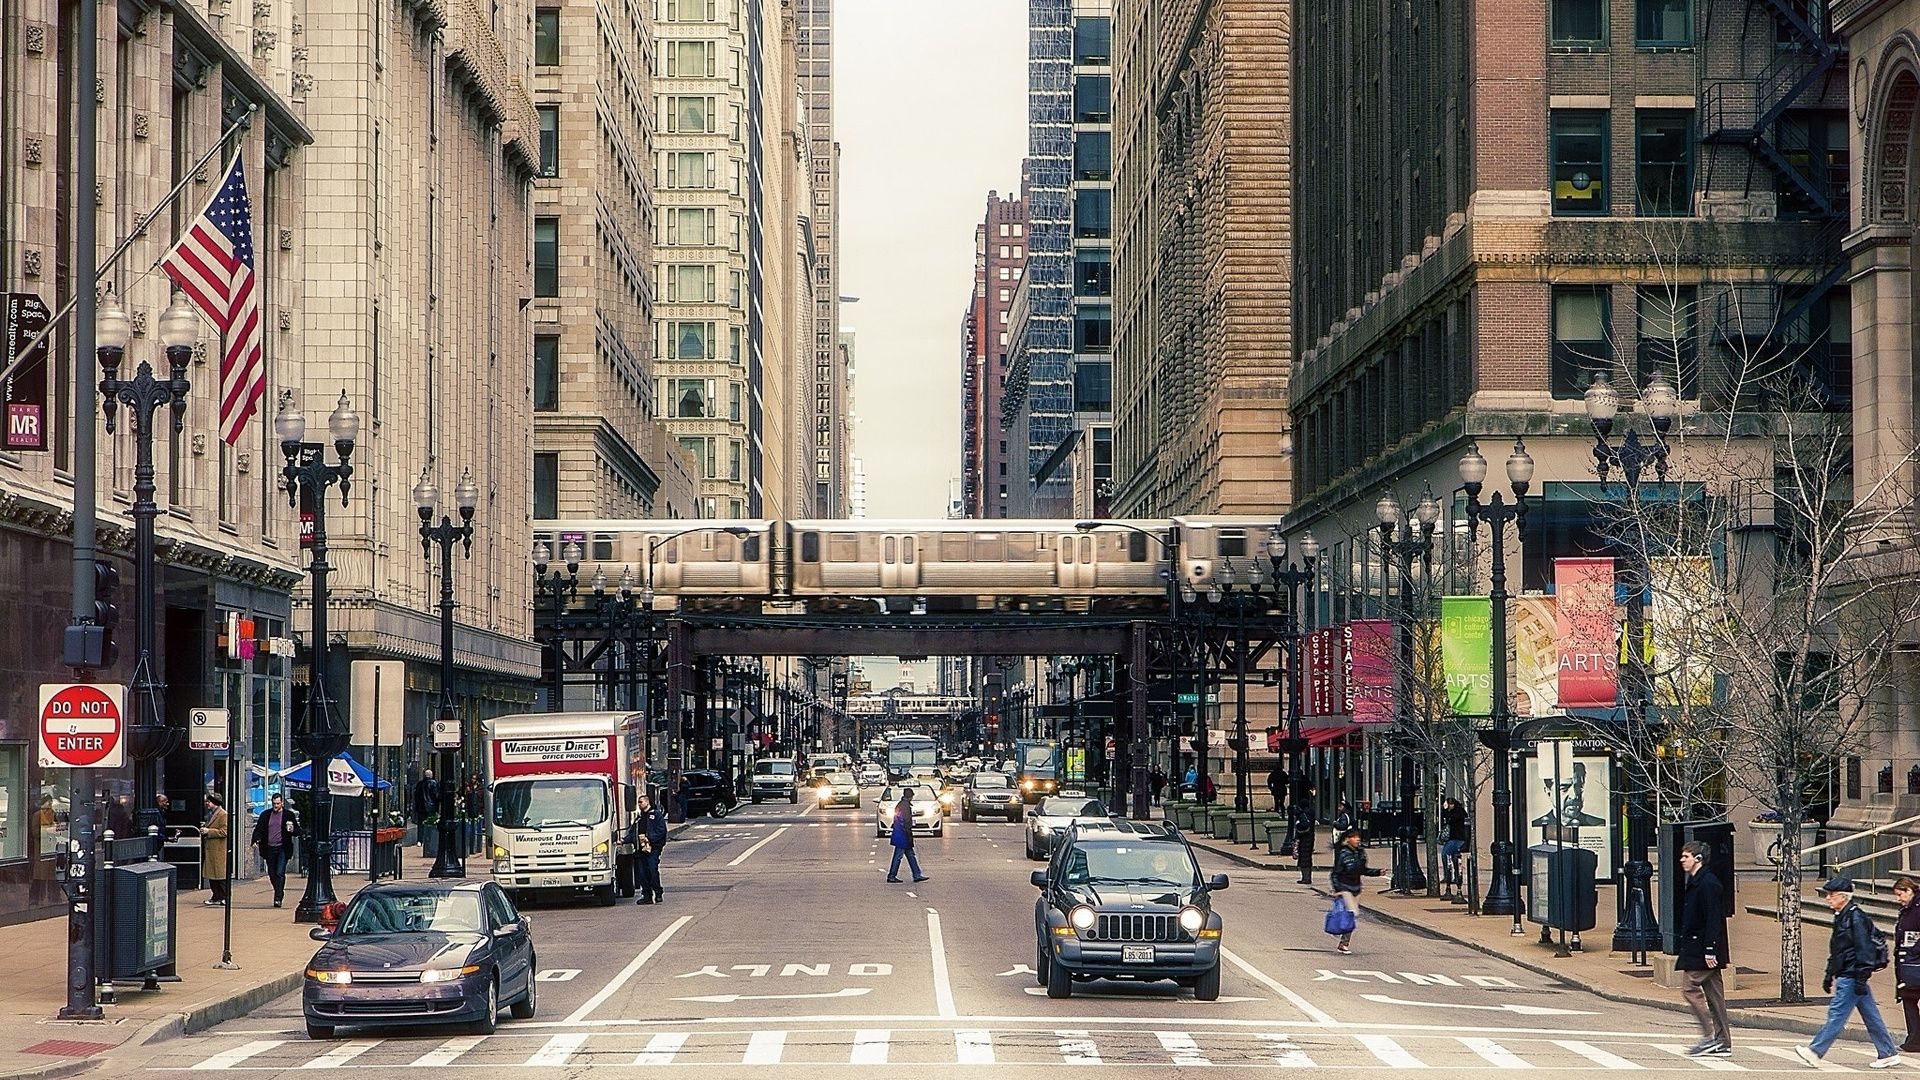

In [2]:
# Pick an image
image_path = os.path.join("images","007.jpg")
display(Image_display(image_path))

### Inception V3

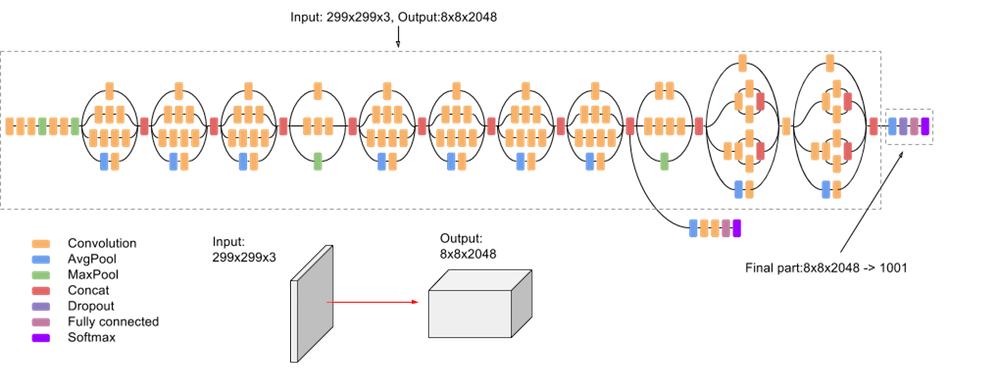

In [3]:
# OpenAI Diagram
display(Image_display(os.path.join("images","INCEPTION.png")))

In [4]:
# Define model
inception_model = Inception_V3()

In [5]:
# Predicted labels
inception_model.predict_classes(image_path, print_results=False)

{'Bell Cote',
 'Cab',
 'Cinema',
 'Forklift',
 'Garbage Truck',
 'Grocery Store',
 'Jinrikisha',
 'Minibus',
 'Streetcar',
 'Trolleybus'}

### OpenAI Clip

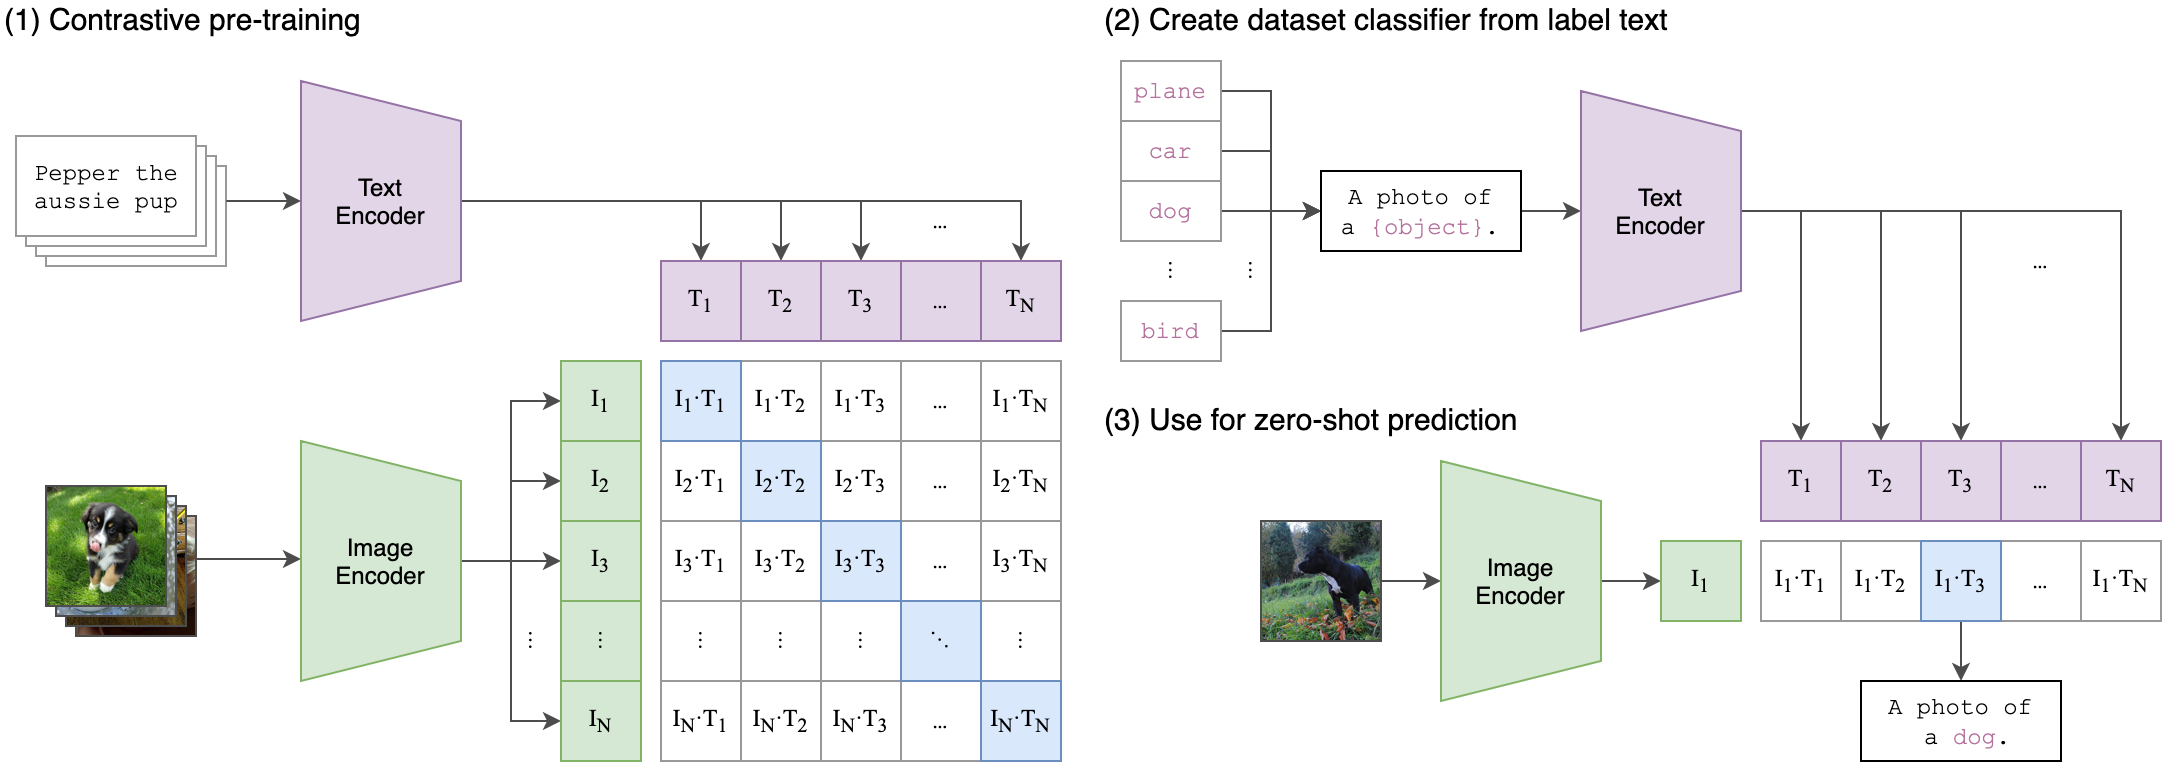

In [6]:
# OpenAI Diagram
display(Image_display(os.path.join("images","CLIP.png")))

In [7]:
# Define model
clip_model = OpenAI_clip()

In [8]:
# Predicted labels
clip_model.predict_classes(image_path, print_results=False)

{'Balance Beam',
 'Cab',
 'Convertible',
 'Horizontal Bar',
 'Parallel Bars',
 'Pole',
 'School Bus',
 'Steel Arch Bridge',
 'Street Sign',
 'Streetcar',
 'Traffic Light',
 'Triumphal Arch',
 'Trolleybus',
 'Turnstile',
 'Viaduct'}

## Labeling the data

In [10]:
# Auxiliary Functions
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    return float(intersection) / union

def similar_image(image):
    scores = []
    for img in image_paths:
        if img != image:
            scores.append(jaccard_similarity(image_labels[image], image_labels[img]))
        else:
            scores.append(0)
    print(scores)
    best_score = image_paths[np.argmax(scores)]
    display(Image_display(image))
    display(Image_display(best_score))

In [9]:
# Image paths
image_paths = [os.path.join("images", f) for f in os.listdir("images") if f.split(".")[-1]=="jpg"]

# Image labels
image_labels = {}
for img in image_paths:
    image_labels[img] = clip_model.predict_classes(img, top=15, print_results=False)

[0.07142857142857142, 0.0, 0.0, 0.36363636363636365, 0.07142857142857142, 0.034482758620689655, 0.0, 0.034482758620689655, 0.0, 0, 0.0, 0.11538461538461539, 0.034482758620689655, 0.07142857142857142, 0.0, 0.0, 0.0, 0.034482758620689655, 0.034482758620689655, 0.0, 0.0]


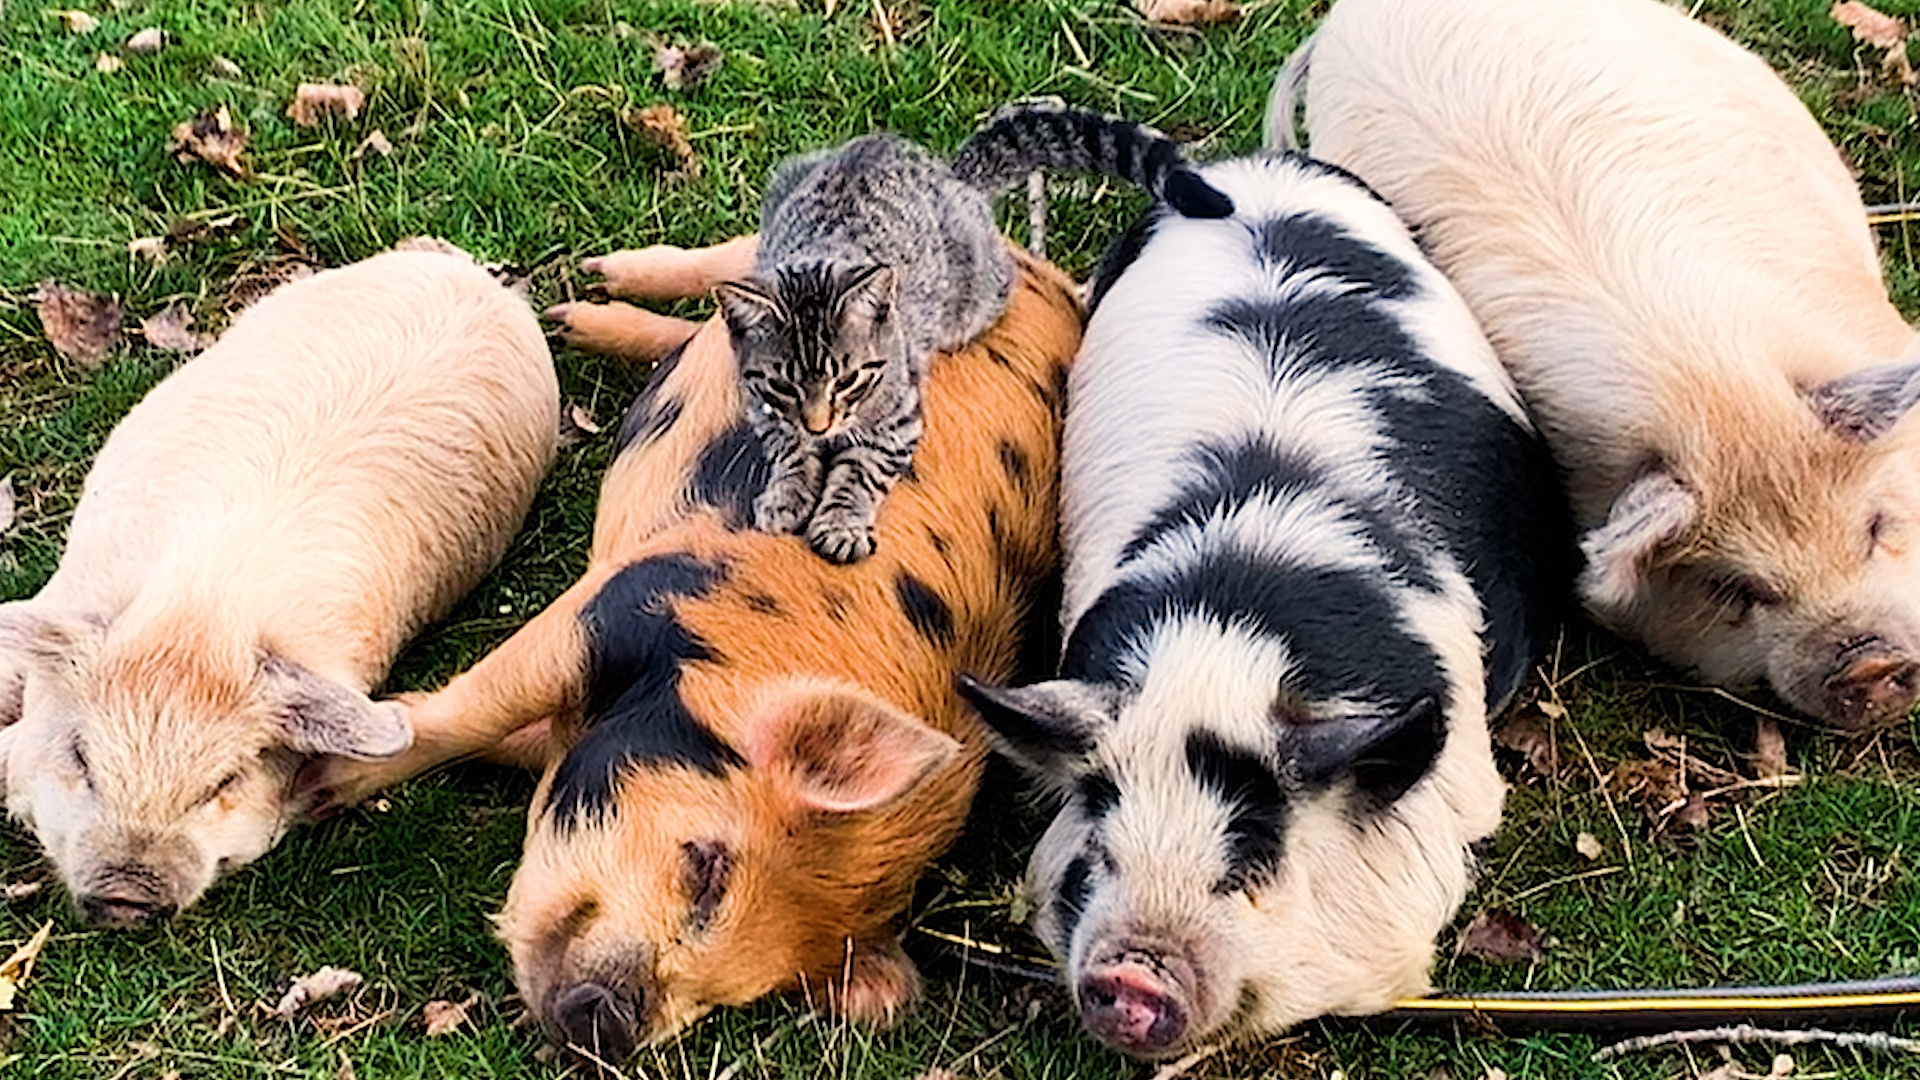

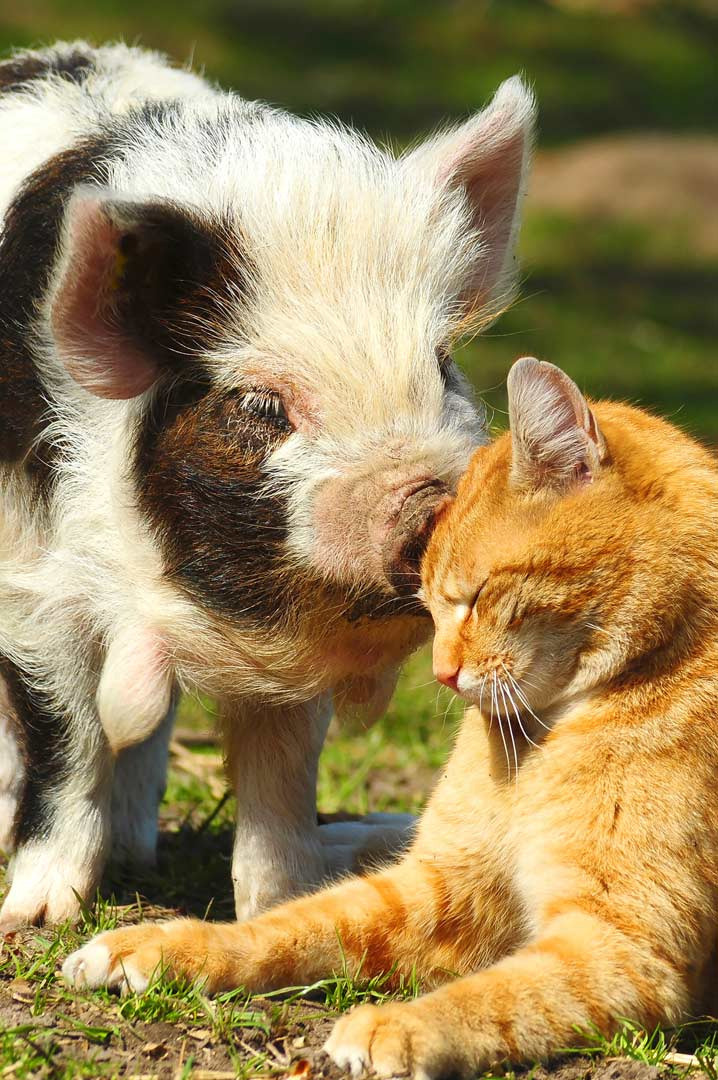

In [11]:
# Find more similar image
similar_image(image_paths[9])

# Sources

https://openai.com/blog/clip/